## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

In [2]:
#читаем данные с Яндекс Диска

df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep = ';')

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
df.shape

(404770, 3)

In [6]:
# Создадим отдельные df для тестовой и контрольной группы по всем пользователям

control = df.query('testgroup == "a"')
test = df.query('testgroup == "b"')

# И только по платящим пользователям

control_paying_users = control.query('revenue > 0')
test_paying_users = test.query('revenue > 0')

In [7]:
# Посмотрим на кол-во пользователей в группах их доход

df.groupby('testgroup', as_index = False).agg({'revenue' : 'sum', 'user_id' : 'nunique'})

,testgroup,revenue,user_id
0,a,5136189,202103
1,b,5421603,202667


Text(0, 0.5, 'Доход')

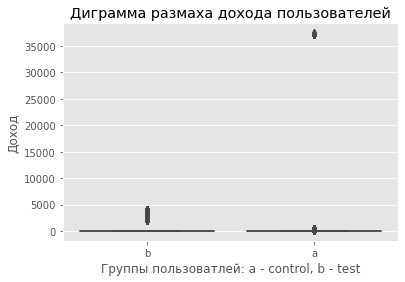

In [8]:
# Построим диаграмму размаха для визуального понимания возможных различий

sns.boxplot(x="testgroup", y="revenue", data=df)
plt.title('Диграмма размаха дохода пользователей')
plt.xlabel('Группы пользоватлей: a - control, b - test')
plt.ylabel('Доход')

Видны выбросы в контрольной группе (a), давайте посмотрим на описательные статистики каждой группы

In [9]:
# Контрольная группа

control.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Text(0, 0.5, 'Плотность')

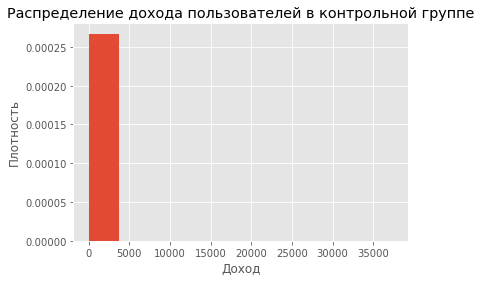

In [10]:
# Визуализируем распределние дохода пользователей в контрольной группе

control.revenue.plot(kind='hist', density = True, bins=10)
plt.title('Распределение дохода пользователей в контрольной группе')
plt.xlabel('Доход')
plt.ylabel('Плотность')

Text(0, 0.5, 'Плотность')

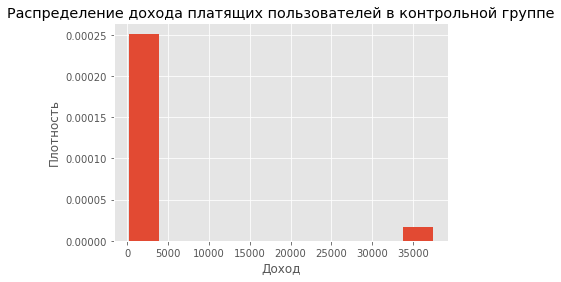

In [11]:
# Визуализируем распределние дохода платящих пользователей в контрольной группе

control_paying_users.revenue.plot(kind='hist', density = True, bins=10)
plt.title('Распределение дохода платящих пользователей в контрольной группе')
plt.xlabel('Доход')
plt.ylabel('Плотность')

In [12]:
'{:.2%}'.format(control.query('revenue > 30000').user_id.nunique() / control.user_id.nunique())

'0.06%'

In [13]:
control.query('revenue > 30000').user_id.nunique()

123

In [14]:
'{:.2%}'.format(control.query('revenue > 30000').revenue.sum()/control.revenue.sum())

'89.37%'

123 пользователя из контрольной группы (это всего 0.06% от всех и 6% от платящих) дают почти 90% дохода
Конечно, мы не можем выкинуть этих пользователей, но должны понимать, что это может отразиться на дальнейших расчетах

In [15]:
# Тестовая группа

test.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Text(0, 0.5, 'Плотность')

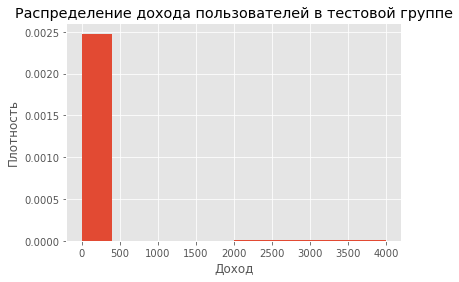

In [16]:
# Визуализируем распределние дохода пользователей в тестовой группе

test.revenue.plot(kind='hist', density = True, bins=10)
plt.title('Распределение дохода пользователей в тестовой группе')
plt.xlabel('Доход')
plt.ylabel('Плотность')

Text(0, 0.5, 'Плотность')

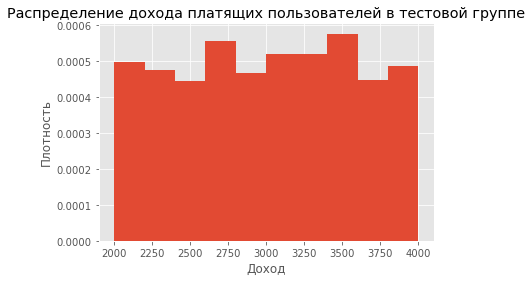

In [17]:
# Визуализируем распределние дохода платящих пользователей в тестовой группе

test_paying_users.revenue.plot(kind='hist', density = True, bins=10)
plt.title('Распределение дохода платящих пользователей в тестовой группе')
plt.xlabel('Доход')
plt.ylabel('Плотность')

Также основная часть пользователей не приносит дохода, но у платящих пользователей нет сильных различий, как в контроле

In [18]:
# Посчитаем конверсию в платящего пользователя

cvr_control = round(control_paying_users.user_id.nunique() / control.user_id.nunique() * 100, 5)
cvr_test = round(test_paying_users.user_id.nunique() / test.user_id.nunique() * 100, 5)

In [19]:
# Проверим разницу CR

'{:.2%}'.format(round((cvr_test/cvr_control-1), 4))

'-6.64%'

Конверсия в тестовой группе ниже на 6.64%



In [20]:
# Рассчитаем ARPU для каждой группы

arpu_control = round((control.revenue.sum() / control_paying_users.user_id.nunique())* cvr_control, 2)
arpu_test = round((test.revenue.sum() / test_paying_users.user_id.nunique())* cvr_test, 2)

In [21]:
# Проверим разницу между ARPU

'{:.2%}'.format(round((arpu_test/arpu_control-1), 4))

'5.26%'

В тестовой группе ARPU выше на 5.26%



Применим тест Шапиро-Уилка, чтобы убедиться, что данные распределены ненормально. Перед применением критерия при проверке на нормальность делаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используем параметр random_state=17 в методе sample.

In [22]:
stats.shapiro(control.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [23]:
stats.shapiro(test.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

Убеждаемся, что данные распределены ненормально, pvalue < 0.05. Дальше будем использовать метод бутстрап и U-критерий Манна-Уитни

In [24]:
def bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статисбутстраптика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values 
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        boot_data.append(statistic([samples_1 - samples_2])) # применяем статистику

        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

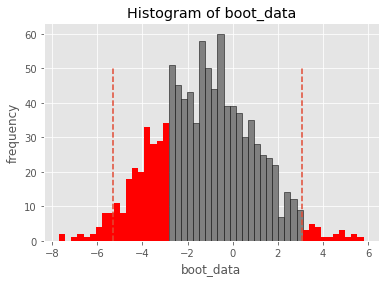

In [25]:
# Используем метод бутстрап для сравнения средних в доходах групп

revenue_data = bootstrap(control.revenue, test.revenue)

In [26]:
# Доверительный интервал

revenue_data['quants']

,0
0.025,-5.317847
0.975,3.062549


In [27]:
# Значение p-value

revenue_data['p_value']

0.5710360403286339

In [28]:
# Считаем U-критерий Манна-Уитни

stats.mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [29]:
# Посмотрим еще на различия между группами в конверсиях в платящего пользователя

In [30]:
# Переводим в булевое значение и создаем новый столбец

df['pay'] = np.where(df.revenue > 0, 1, 0)

cvr_df = df.groupby(['user_id', 'testgroup'], as_index=False) \
        .agg({'revenue':'count','pay':'sum'}) \
        .rename(columns = {'revenue':'visits', 'pay':'number_of_purchase'})

cvr_df['cvr'] = cvr_df.number_of_purchase/cvr_df.visits

  0%|          | 0/1000 [00:00<?, ?it/s]

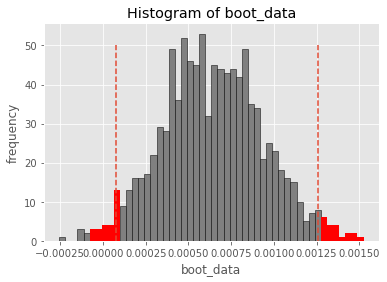

In [31]:
cvr_control = cvr_df.query('testgroup == "a"').cvr
cvr_test = cvr_df.query('testgroup == "b"').cvr
cvr_data = bootstrap(cvr_control, cvr_test)

In [32]:
# Доверительный интервал

cvr_data['quants']

,0
0.025,0.000079
0.975,0.001258


In [33]:
# Значение p-value

cvr_data['p_value']

0.03118751198246732

In [34]:
# Считаем U-критерий Манна-Уитни

stats.mannwhitneyu(cvr_control, cvr_test)

MannwhitneyuResult(statistic=20492777381.0, pvalue=0.035028756899158665)

# Вывод

Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Равенство распределений значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). 

Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). 

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяем бутстрап с оценкой среднего, мы не можем отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия. U-критерий Манна-Уитни также не дает нам отклонить нулевую гипотезу
* Хоть и разность конверсий статистически значима, это не позволяет нам считать одну из групп предпочтительным вариантом.
* Нам необходимо больше данных, чтобы ответитть на дополнительные вопросы. Важно посчитать retention, LTV, посмотреть на воронки конверсии. В контрольной группе есть большие выбросы, чем они могут быть обусловлены? Посмотреть по каким источникам трафика/страны приходили платящие и неплатящие пользователи